In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importamos las librerías que utilizaremos**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Cargamos ahora el conjunto de datos**

In [ ]:
%cd /content/drive/MyDrive/DSA/Datos/Churn/ClientesTelco

df = pd.read_csv('Telco-Customer-Churn.csv')

/content/drive/MyDrive/DSA/Datos/Churn/ClientesTelco


**Mostramos la primera fila y la informacion del DataFrame**

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Podemos notar entonces que cada usuario se identifica a través de un ID de cliente único.
Hay 19 variables independientes que se utilizan para predecir la función objetivo: el abandono o rotación de clientes.
En este conjunto de datos la rotacion de clientes se define como los usuarios que se fueron el último mes.

**Contamos los valores de la variable objetivo**

In [ ]:
df [ 'Churn' ].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Solo al rededor del 27% de los clientes en el conjunto de datos han abandonado. Esto significa que estamos ante un problema de clasificación desequilibrada.
Sería óptimo realizar un poco de feature Engineering para crear un conjunto de datos de entrenamiento equilibrado antes de construir el modelo predictivo.

**Análisis exploratorio de los datos**

El análisis de los datos nos brindará una mejor comprensión de las variables independientes en el conjunto de datos y su relación con la rotación de clientes.
Para ello visualizaremos algunas columnas categóricas

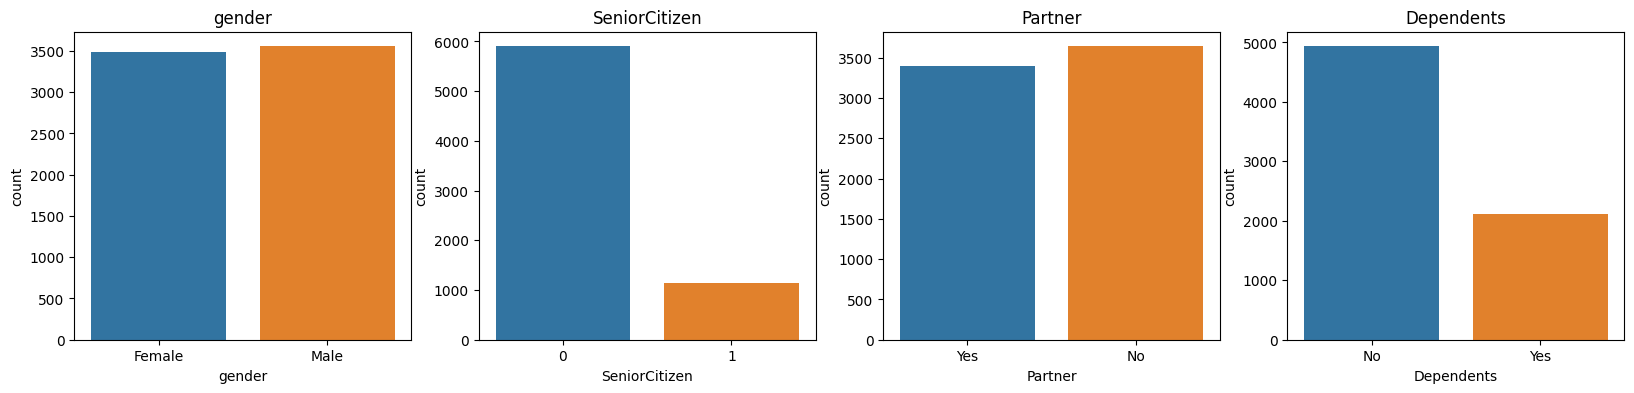

In [ ]:
cols = ['gender','SeniorCitizen',"Partner","Dependents"]
numerical = cols
plt.figure(figsize=(20,4))
for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=df)
    ax.set_title(f"{col}")

La mayoría de los clientes en el conjunto de datos son personas jóvenes sin hijos.
Existe una distribución equitativa del género del usuario y el estado civil.

**Relación entre el costo del servicio y la rotación de clientes**

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

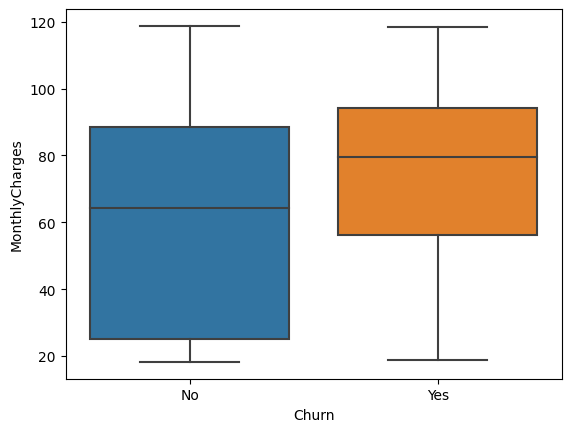

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)

Los clientes que abandonaron tienen un cargo mensual promedio más alto que los clientes que renovaron su suscripción.

Analizamos la relación entre la rotación del cliente y algunas otras variables categóricas capturadas en el conjunto de datos

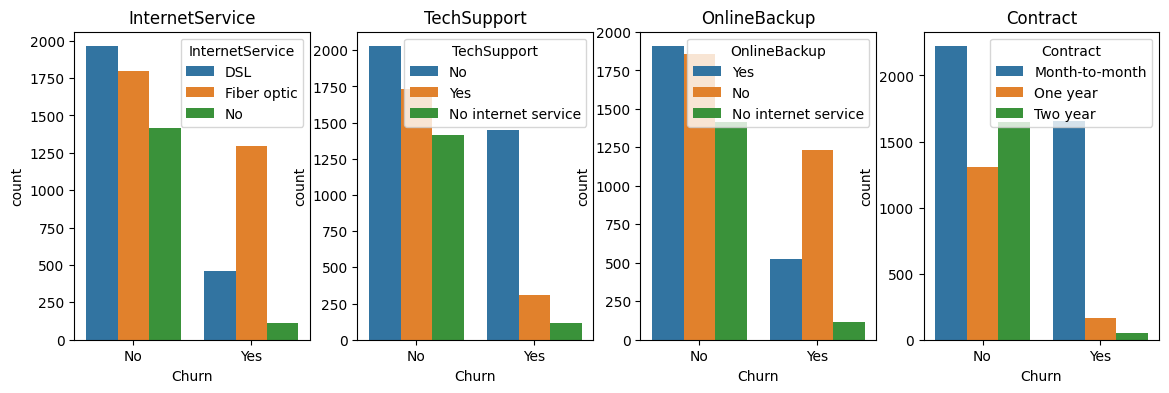

In [ ]:
cols = ['InternetService',"TechSupport","OnlineBackup","Contract"]
plt.figure(figsize=(14,4))
for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = df)
    ax.set_title(f"{col}")

**Servicio de Internet:** es claro a partir de la imagen anterior que los clientes que usan
Internet de fibra óptica se retiran con más frecuencia que otros usuarios. Esto puede
deberse a que Internet por fibra es un servicio más costoso o que este proveedor no
tiene una buena cobertura.

**Soporte técnico:** muchos usuarios que abandonaron no se registraron para recibir soporte técnico. Esto podría significar que estos clientes no recibieron ninguna orientación sobre cómo solucionar problemas técnicos y decidieron dejar de usar el servicio.

**Copia de seguridad en línea:** muchos clientes que se habían retirado no se registraron
en un servicio de copia de seguridad en línea para el almacenamiento de datos.

**Contrato:** los usuarios que abandonaron casi siempre tenían un contrato mensual. Esto
tiene sentido, ya que estos clientes pagan el servicio mensualmente y pueden cancelar
fácilmente su suscripción antes del próximo ciclo de pago.

Un análisis simple basado en datos como este puede ayudar a las organizaciones a comprender por qué están perdiendo clientes y qué pueden hacer al respecto.

Por ejemplo, si la compañía se da cuenta de que la mayoría de sus usuarios que abandonaron no se han inscrito en el soporte técnico, podría incluirse esto como un servicio gratuito en algunas de sus futuras ofertas de productos para evitar que otros clientes se vayan.

# Preprocesamiento de datos para aprender sobre la rotación de clientes

Realizamos una preparación de datos antes de crear el modelo de aprendizaje automático.

a) Limpiar el conjunto de datos: La variable "TotalCharges" tiene el tipo de datos "Objeto", cuando debe ser una columna numérica. Convertimos esta columna en una numérica y eliminamos valores nulos:

In [ ]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: pd.to_numeric(x,
errors='coerce')).dropna()

b) Codificación de variables categóricas

Separamos las variables categóricas


In [ ]:
cat_features = df.drop(['customerID','TotalCharges','MonthlyCharges', 'SeniorCitizen','tenure'], axis=1)


Aplicamos la codificación de etiquetas a las características categóricas

In [ ]:
le = preprocessing.LabelEncoder()
df_cat = cat_features.apply(le.fit_transform)
df_cat.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


Combinamos el data frame que acabamos de crear con el anterior

In [ ]:
num_features = df[['customerID','TotalCharges','MonthlyCharges','SeniorCitizen','tenure']]
finaldf = pd.merge(num_features, df_cat, left_index=True, right_index=True)

c) Oversampling

Dividimos los datos en conjuntos de entrenamiento y prueba

In [ ]:
finaldf = finaldf.dropna()
finaldf = finaldf.drop(['customerID'], axis=1)
X = finaldf.drop(['Churn'], axis=1)
y = finaldf['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Mostramos el conjunto de entrenamiento de datos.
Aplicamos SMOTE para abordar el desequilibrio de clases

In [ ]:
oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote

Verificamos el número de muestras en cada clase para asegurar que sean iguales

In [ ]:
y_train.value_counts()

0    3452
1    3452
Name: Churn, dtype: int64

Ahora el conjunto de datos esta equilibrado, crearemos entonces un clasificador de bosque aleatorio para la predecir la rotación del cliente.

In [ ]:
rf = RandomForestClassifier(random_state=46)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=46)

Veamos ahora las predicciones del modelo en el conjunto de datos de prueba

In [ ]:
preds = rf.predict(X_test)
print(accuracy_score(preds, y_test))

0.7656182679879362


Nuestro modelo funciona bien, con una precisión del 0.77 en el conjunto de datos de prueba

Se ha tomado un conjunto de datos con los abandonos registrado, se los ha tratado, se entrenó a un subconjunto de datos, se lo probo y con el grado de seguridad se decide aplicarle los datos nuevos para realizar una predicción sobre si van a abandonar o no el servicio.